In [53]:
import importlib
import types


def walk_reload(module: types.ModuleType) -> None:
    if hasattr(module, "__all__"):
        for submodule_name in module.__all__:
            walk_reload(getattr(module, submodule_name))
    importlib.reload(module)

import io
from utils import XML
from utils import RateInstruments
from utils import RateCurve
#import importlib
walk_reload(XML)
walk_reload(RateInstruments)
walk_reload(RateCurve)

import numpy as np
from urllib.request import urlopen
from datetime import datetime
from dateutil.relativedelta import *



In [54]:
# get the OIS curves (already calibrated) from the markit website
curveURL = "http://www.markit.com/news/InterestRates_USD_20180105.zip"
USD_ratecurve = RateCurve.RateCurve(curveURL)

In [55]:
dep = RateInstruments.DepositInstrument(datetime(2018,1,10), datetime(2018,4,10), 2/100, USD_ratecurve)
dep.getZCsensi()

[computeNonDiscountedFlows]
Elapsed: 0.04738879203796387
[computeDiscountedFlows]
Elapsed: 0.057118892669677734


2018-02-12    0.000000
2018-03-12    0.000000
2018-04-10   -0.246769
2018-07-10    0.000000
2019-01-10    0.000000
2020-01-10    0.000000
2021-01-10    0.000000
2022-01-10    0.000000
2023-01-10    0.000000
2024-01-10    0.000000
2025-01-10    0.000000
2026-01-10    0.000000
2027-01-10    0.000000
2028-01-10    0.000000
2030-01-10    0.000000
2033-01-10    0.000000
2038-01-10    0.000000
2043-01-10    0.000000
2048-01-10    0.000000
dtype: float64

In [56]:
swap = RateInstruments.FixFloatSwapInstrument(datetime(2018,1,10), datetime(2018,1,10) + relativedelta(years=2), 2, 6, 3, 2/100, USD_ratecurve, USD_ratecurve)
swap.getZCsensi()

[computeNonDiscountedFlows]
Elapsed: 0.19959712028503418
[computeDiscountedFlows]
Elapsed: 0.13741302490234375


2018-02-12    0.000000e+00
2018-03-12    0.000000e+00
2018-04-10    2.775558e-17
2018-07-10    4.940547e-03
2019-01-10    1.734786e-02
2020-01-10    1.942746e+00
2021-01-10    0.000000e+00
2022-01-10    0.000000e+00
2023-01-10    0.000000e+00
2024-01-10    0.000000e+00
2025-01-10    0.000000e+00
2026-01-10    0.000000e+00
2027-01-10    0.000000e+00
2028-01-10    0.000000e+00
2030-01-10    0.000000e+00
2033-01-10    0.000000e+00
2038-01-10    0.000000e+00
2043-01-10    0.000000e+00
2048-01-10    0.000000e+00
dtype: float64

In [57]:
# deposits interpolation
size = USD_ratecurve.df.shape[0]
filter_deposits = USD_ratecurve.df['source']=='deposit'
filter_swaps = USD_ratecurve.df['source']=='swap'
ytms = USD_ratecurve.df[filter_deposits]['YTM']
parrates = USD_ratecurve.df[USD_ratecurve.df['source']=='deposit']['parrate']
discounts = 1/(1+ytms*parrates)
USD_ratecurve.df.loc[USD_ratecurve.df['source']=='deposit','df'] = discounts
USD_ratecurve.df.loc[USD_ratecurve.df['source']=='deposit','ZCrate'] = -ytms*np.log(discounts)
USD_ratecurve.df

,source,tenor,parrate,YTM,ZCrate,df
maturity,,,,,,
2018-02-12,deposit,1M,0.015525,0.083333,0.000108,0.998708
2018-03-12,deposit,2M,0.016219,0.166667,0.000450,0.997304
2018-04-10,deposit,3M,0.017039,0.250000,0.001063,0.995758
2018-07-10,deposit,6M,0.018651,0.500000,0.004641,0.990761
2019-01-10,deposit,1Y,0.021495,1.000000,0.021267,0.978957
2020-01-10,swap,2Y,0.021470,2.000000,0.021470,0.000000
2021-01-10,swap,3Y,0.022405,3.000000,0.022405,0.000000
2022-01-10,swap,4Y,0.022930,4.000000,0.022930,0.000000
2023-01-10,swap,5Y,0.023225,5.000000,0.023225,0.000000


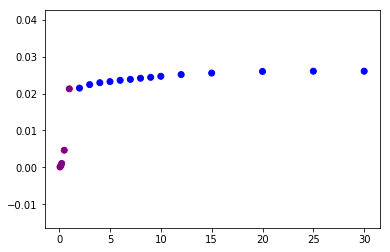

[computeNonDiscountedFlows]
Elapsed: 0.04758810997009277
[computeDiscountedFlows]
Elapsed: 0.04797005653381348
[computeNonDiscountedFlows]
Elapsed: 0.0437922477722168
[computeDiscountedFlows]
Elapsed: 0.0399019718170166
[computeNonDiscountedFlows]
Elapsed: 0.030321121215820312
[computeDiscountedFlows]
Elapsed: 0.03397417068481445
[computeNonDiscountedFlows]
Elapsed: 0.03018498420715332
[computeDiscountedFlows]
Elapsed: 0.038702964782714844
[computeNonDiscountedFlows]
Elapsed: 0.037142038345336914
[computeDiscountedFlows]
Elapsed: 0.04389190673828125
[computeNonDiscountedFlows]
Elapsed: 0.16485190391540527
[computeDiscountedFlows]
Elapsed: 0.122161865234375
[computeNonDiscountedFlows]
Elapsed: 0.1868889331817627
[computeDiscountedFlows]
Elapsed: 0.16801691055297852
[computeNonDiscountedFlows]
Elapsed: 0.24939417839050293
[computeDiscountedFlows]
Elapsed: 0.22194194793701172
[computeNonDiscountedFlows]
Elapsed: 0.3406648635864258
[computeDiscountedFlows]
Elapsed: 0.35677385330200195
[com

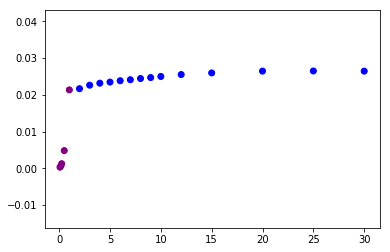

[computeNonDiscountedFlows]
Elapsed: 0.03806781768798828
[computeDiscountedFlows]
Elapsed: 0.04897809028625488
[computeNonDiscountedFlows]
Elapsed: 0.035822153091430664
[computeDiscountedFlows]
Elapsed: 0.04029679298400879
[computeNonDiscountedFlows]
Elapsed: 0.03189992904663086
[computeDiscountedFlows]
Elapsed: 0.03484702110290527
[computeNonDiscountedFlows]
Elapsed: 0.034902095794677734
[computeDiscountedFlows]
Elapsed: 0.033918142318725586
[computeNonDiscountedFlows]
Elapsed: 0.029147863388061523
[computeDiscountedFlows]
Elapsed: 0.03288078308105469
[computeNonDiscountedFlows]
Elapsed: 0.13799214363098145
[computeDiscountedFlows]
Elapsed: 0.11794424057006836
[computeNonDiscountedFlows]
Elapsed: 0.11917591094970703


KeyboardInterrupt: 

In [58]:
USD_ratecurve.calibrateCurve()

In [ ]:
USD_ratecurve.df